# Parallelize Python code with Dask Delayed

## General Python code

In [4]:
import csv

import requests
from dagster_dask import dask_executor
from dagster import get_dagster_logger, job, op, Out
from dagster import fs_io_manager

import numpy as np

import itk
import vtk
from itkwidgets import view
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models
import matplotlib.pyplot as plt

import sys
sys.path.append("/data/OAI_analysis_2/oai_analysis_2")

import mesh_processing as mp
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [17]:
# All Function Definitions

def download_data():
    os.system('girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData')
    
    get_dagster_logger().info('Data download done')

    image_preprocessed = "./OAIData/atlas_image.nii.gz"
    atlas_image = "./OAIData/atlas_image.nii.gz"
    return image_preprocessed, atlas_image

@delayed(nout=2)
def read_images(image_preprocessed, atlas_image):
    image_A = itk.imread(image_preprocessed, itk.D)
    image_B = itk.imread(atlas_image, itk.D)
    return image_A, image_B

@delayed
def register_images(image_A, image_B):
    model = pretrained_models.OAI_knees_registration_model()
    model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)

    get_dagster_logger().info('Image Registration Done')
    return phi_AB

@delayed(nout=2)
def deform_probmap(phi_AB, image_A, image_B):
    fc_prob_file = './OAIData/FC_probmap.nii.gz'
    tc_prob_file = './OAIData/TC_probmap.nii.gz'

    FC_prob = itk.imread(fc_prob_file)
    TC_prob = itk.imread(tc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    warped_image_FC = itk.resample_image_filter(FC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    warped_image_TC = itk.resample_image_filter(TC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    get_dagster_logger().info('Image Deformation Done')
    return warped_image_FC, warped_image_TC

@delayed(nout=2)
def get_thickness_dask(image, mesh_type):
    inner_FC, outer_FC = mp.get_thickness_mesh(image, mesh_type=mesh_type)
    return inner_FC, outer_FC
    
@delayed(nout=2)
def get_thickness(warped_image_FC, warped_image_TC):
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')

    get_dagster_logger().info('Thickness Computation Done')

    return distance_inner_FC, distance_inner_TC

@delayed(nout=2)
def get_paths():
    image_preprocessed = "./OAIData/atlas_image.nii.gz"
    atlas_image = "./OAIData/atlas_image.nii.gz"

    return image_preprocessed, atlas_image

@delayed(nout=2)
def register_and_deform(image_A, image_B):
    phi_AB                               = register_images(image_A=image_A, image_B=image_B)
    warped_image_FC, warped_image_TC     = deform_probmap(phi_AB=phi_AB, image_A=image_A, image_B=image_B)
    return warped_image_FC, warped_image_TC

@delayed
def entire_job(warped_image_FC, warped_image_TC):
    distance_inner_FC, distance_inner_TC = get_thickness(warped_image_FC=warped_image_FC, warped_image_TC=warped_image_TC)

    writer1 = vtk.vtkPolyDataWriter()
    writer1.SetFileName('distance_inner_FC.vtk')
    writer1.SetInputData(distance_inner_FC)
    writer1.Update()

    writer2 = vtk.vtkPolyDataWriter()
    writer2.SetFileName('distance_inner_TC.vtk')
    writer2.SetInputData(distance_inner_TC)
    writer2.Update()

@delayed
def thickness_compute():
    #image_preprocessed, atlas_image = download_data()
    #image_preprocessed = "./OAIData/atlas_image.nii.gz"
    #atlas_image = "./OAIData/atlas_image.nii.gz"

    #image_preprocessed, atlas_image =  get_paths()
    
    # In ITKrc3 images can be serialized
    image_preprocessed, atlas_image   = get_paths()
    image_A, image_B                  = read_images(image_preprocessed, atlas_image)
    warped_image_FC, warped_image_TC  = register_and_deform(image_A, image_B)
    
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    
    return distance_inner_FC, distance_inner_TC
    # Rest all the processing is done here
    # After mesh serialization this can be splitted into smaller components
    # Also working on Transform serialization
    #entire_job(warped_image_FC, warped_image_TC)

## Dask Delayed

In [5]:
from dask.distributed import Client, progress
client = Client(n_workers=1)
client

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34913 instead


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34913/status,
Dashboard: http://127.0.0.1:34913/status,Workers: 1
Total threads: 16,Total memory: 125.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44393,Workers: 1
Dashboard: http://127.0.0.1:34913/status,Total threads: 16
Started: Just now,Total memory: 125.73 GiB
Comm: tcp://127.0.0.1:41219,Total threads: 16
Dashboard: http://127.0.0.1:41105/status,Memory: 125.73 GiB
Nanny: tcp://127.0.0.1:44507,


Open the dashboards!

In [6]:
from dask import delayed, compute, visualize

In [16]:
warped_image_FC

Delayed('getitem-211c86f37763534c9f1abf7c76d50697')

In [18]:
image_preprocessed, atlas_image   = get_paths()

image_A, image_B                  = read_images(image_preprocessed, atlas_image)
warped_image_FC, warped_image_TC  = register_and_deform(image_A, image_B)

distance_inner_FC, distance_outer_FC = get_thickness_dask(warped_image_FC, mesh_type='FC')
distance_inner_TC, distance_outer_TC = get_thickness_dask(warped_image_TC, mesh_type='TC')

**Note:** Don't do `delayed(inc(i))`

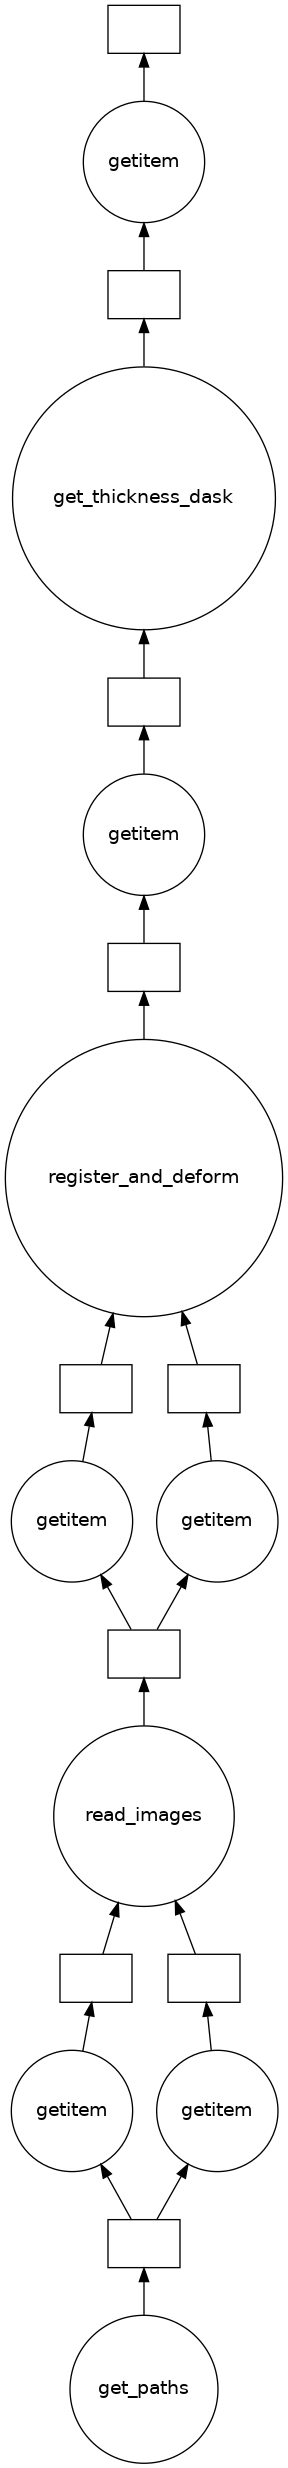

In [19]:
visualize(distance_inner_FC)

**Note:** Try to minimize computing.

In [13]:
%%time

l = compute(*l)
l

CPU times: user 82 ms, sys: 20.2 ms, total: 102 ms
Wall time: 2.08 s


(0, 2, 4, 6, 8)

### Alternatively...

In [14]:
@delayed
def inc(x):
    sleep(1)
    return x + 1

@delayed
def dec(x):
    sleep(1)
    return x - 1

@delayed
def add(x, y):
    sleep(1)
    return x + y

Or:

In [ ]:
# inc = delayed(inc)
# dec = delayed(dec)
# add = delayed(add)

In [15]:
%%time

l = []

for i in range(10):
    a = inc(i)
    b = dec(i)
    c = add(a, b)
    l.append(c)
    
l = compute(*l)

CPU times: user 57.5 ms, sys: 5.59 ms, total: 63.1 ms
Wall time: 3.02 s


## Another example: pandas

In [ ]:
# !wget https://coiled-datasets.s3.us-east-2.amazonaws.com/seattle-library-checkouts/checkouts-subset.csv

In [12]:
import pandas as pd

In [13]:
%%time

ddf = delayed(pd.read_csv)("checkouts-subset.csv", 
                           engine='python', 
                           error_bad_lines=False) # with delayed

CPU times: user 472 µs, sys: 232 µs, total: 704 µs
Wall time: 552 µs


In [14]:
%%time

result = ddf.groupby("UsageClass").Checkouts.sum()

CPU times: user 317 µs, sys: 62 µs, total: 379 µs
Wall time: 358 µs


In [15]:
result

Delayed('sum-74b130a7-b58b-4da5-9a4a-4b16a731a16f')

In [16]:
result.compute()

UsageClass
Digital      8772938
Physical    52609482
Name: Checkouts, dtype: int64

In [17]:
client.close()

**Note:** Dask DataFrame is better for parallelizing pandas